run serial_construct_matrix with time: 0.005672411999512406
(18, 18)
iter   1:
iter   2:
iter   3:
iter   4:
iter   5:
iter   6:
iter   7:
iter   8:
iter   9:
iter  10:
iter  11:
iter  12:
Convergence info: 0
Number of iteration of pcg: 12
time: 0.030664065999189916


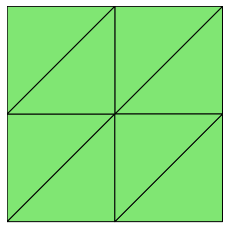

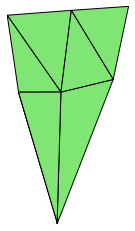

In [1]:
import sys

import numpy as np
from scipy.sparse.linalg import spsolve, cg, LinearOperator, spilu
from scipy.sparse import spdiags

import matplotlib.pyplot as plt

from fealpy.decorator import cartesian
from fealpy.mesh import TriangleMesh
from fealpy.functionspace import LagrangeFiniteElementSpace
from fealpy.boundarycondition import DirichletBC, NeumannBC

import pyamg
from timeit import default_timer as timer

class BoxDomain2DData():
    def __init__(self, E=1e+5, nu=0.2):
        self.E = E 
        self.nu = nu
        self.lam = self.nu*self.E/((1+self.nu)*(1-2*self.nu))
        self.mu = self.E/(2*(1+self.nu))

    def domain(self):
        return [0, 1, 0, 1]

    def init_mesh(self, n=3, meshtype='tri'):
        node = np.array([
            (0, 0),
            (1, 0),
            (1, 1),
            (0, 1)], dtype=np.float64)
        cell = np.array([(1, 2, 0), (3, 0, 2)], dtype=np.int64)
        mesh = TriangleMesh(node, cell)
        mesh.uniform_refine(n)
        return mesh 

    @cartesian
    def displacement(self, p):
        return 0.0

    @cartesian
    def jacobian(self, p):
        return 0.0

    @cartesian
    def strain(self, p):
        return 0.0

    @cartesian
    def stress(self, p):
        return 0.0

    @cartesian
    def source(self, p):
        
        x = p[..., 0]
        y = p[..., 1]
        
        val = np.zeros_like(p)
        
        val[..., 0] = -((12 * x**2 - 12 * x + 2) * (4 * y **3 - 6 * y**2 + 2 * y) + (x - x**2)**2 * (24 * y - 12))
        val[..., 1] = (24 * x - 12) * (y - y**2)**2 + (4 * x**3 - 6 * x**2 + 2 * x) * (12 * y**2 - 12 * y + 2)
        
        #val = np.array([0.0, 0.0], dtype=np.float64)
        #shape = len(p.shape[:-1])*(1, ) + (2, )
        #return val.reshape(shape)
        return val

    @cartesian
    def dirichlet(self, p):
        val = np.array([0.0, 0.0], dtype=np.float64)
        shape = len(p.shape[:-1])*(1, ) + (2, )
        return val.reshape(shape)

    @cartesian
    def neumann(self, p, n):
        val = np.array([-500, 0.0], dtype=np.float64)
        shape = len(p.shape[:-1])*(1, ) + (2, )
        return val.reshape(shape)

    @cartesian
    def is_dirichlet_boundary(self, p):
        x = p[..., 0]
        y = p[..., 1]
        flag = np.abs(x) < 1e-13
        return flag

    @cartesian
    def is_neumann_boundary(self, p):
        x = p[..., 0]
        y = p[..., 1]
        flag = np.abs(x - 1) < 1e-13
        return flag

    @cartesian
    def is_fracture_boundary(self, p):
        pass

class Model2d():
    def __init__(self, lam=1.0, mu=0.5):
        self.lam = lam
        self.mu = mu

    def init_mesh(self, n=4):
        #from ..mesh import TriangleMesh
        node = np.array([
            (0, 0),
            (1, 0),
            (1, 1),
            (0, 1)], dtype=np.float64)
        cell = np.array([(1, 2, 0), (3, 0, 2)], dtype=np.int64)

        mesh = TriangleMesh(node, cell)
        mesh.uniform_refine(n)
        return mesh 

    @cartesian
    def displacement(self, p):
        x = p[..., 0]
        y = p[..., 1]
        pi = np.pi
        val = np.zeros(p.shape, dtype=np.float64)
        val[..., 0] = np.exp(x - y)*x*(1 - x)*y*(1 - y)
        val[..., 1] = np.sin(pi*x)*np.sin(pi*y)
        return val

    @cartesian
    def grad_displacement(self, p):
        x = p[..., 0]
        y = p[..., 1]

        sin = np.sin
        cos = np.cos
        pi = np.pi
        e = np.exp(x - y)

        shape = p.shape + (2, )
        val = np.zeros(shape, dtype=np.float64)
        val[..., 0, 0] = e*(x*y*(-x + 1)*(-y + 1) - x*y*(-y + 1) + y*(-x + 1)*(-y + 1))
        val[..., 0, 1] = e*(-x*y*(-x + 1)*(-y + 1) - x*y*(-x + 1) + x*(-x + 1)*(-y + 1))
        val[..., 1, 0] = pi*sin(pi*y)*cos(pi*x)
        val[..., 1, 1] = pi*sin(pi*x)*cos(pi*y)
        return val

    @cartesian
    def stress(self, p):
        lam = self.lam
        mu = self.mu
        du = self.grad_displacement(p)
        Au = (du + du.swapaxes(-1, -2))/2
        val = 2*mu*Au
        val[..., range(2), range(2)] += lam*Au.trace(axis1=-2, axis2=-1)[..., np.newaxis]
        return val
        

    @cartesian
    def compliance_tensor(self, phi):
        lam = self.lam
        mu = self.mu
        aphi = phi.copy()
        t = np.sum(aphi[..., 0:2], axis=-1)
        aphi[..., 0:2] -= lam/(2*mu+2*lam)*t[..., np.newaxis]
        aphi /= 2*mu
        return aphi

    @cartesian
    def div_stress(self, p):
        return -self.source(p)

    @cartesian
    def source(self, p):
        lam = self.lam
        mu = self.mu
        x = p[..., 0]
        y = p[..., 1]

        sin = np.sin
        cos = np.cos
        pi = np.pi


        ss = sin(pi*x)*sin(pi*y)
        cc = cos(pi*x)*cos(pi*y)
        e = np.exp(x - y)
        t0 = (-x + 1)*(-y + 1)

        val = np.zeros(p.shape, dtype=np.float64)
        val[..., 0] -= lam*(pi**2*cc + e*t0*x*y + 2*e*t0*y - 2*e*x*y*(-y + 1) - 2*e*y*(-y + 1)) 
        val[..., 0] -= 2*mu*(e*t0*x*y + 2*e*t0*y - 2*e*x*y*(-y + 1) - 2*e*y*(-y + 1)) 
        val[..., 0] -= 2*mu*(pi**2*cc/2 + e*t0*x*y/2 - e*t0*x + e*x*y*(-x + 1) - e*x*(-x + 1))

        val[..., 1] -= lam*(-e*t0*x*y + e*t0*x - e*t0*y + e*t0 - e*x*y*(-x + 1) + e*x*y*(-y + 1) + e*x*y - e*x*(-y + 1) - e*y*(-x + 1) - pi**2*ss)
        val[..., 1] += 2*pi**2*mu*ss 
        val[..., 1] -= 2*mu*(-e*t0*x*y/2 + e*t0*x/2 - e*t0*y/2 + e*t0/2 - e*x*y*(-x + 1)/2 + e*x*y*(-y + 1)/2 + e*x*y/2 - e*x*(-y + 1)/2 - e*y*(-x + 1)/2 - pi**2*ss/2)
        return val

    @cartesian
    def dirichlet(self, p):
        return self.displacement(p)
    
    @cartesian
    def neumann(self, p, n):
        val = np.array([0.0, 0.0], dtype=np.float64)
        shape = len(p.shape[:-1])*(1, ) + (2, )
        return val.reshape(shape)
    
    @cartesian
    def is_dirichlet_boundary(self, p):
        x = p[..., 0]
        y = p[..., 1]
        flag = np.abs(x) < 1e-13
        return flag

    @cartesian
    def is_neumann_boundary(self, p):
        x = p[..., 0]
        y = p[..., 1]
        flag = np.abs(x - 1) < 1e-13
        return flag

    
class IterationCounter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1
        if self._disp:
            print('iter %3i:' % (self.niter))

class LinearElasticityLFEMFastSolver():
    def __init__(self, A, P, isBdDof):
        """
        Notes
        -----

        这里的边界条件处理放到矩阵和向量的乘积运算当中, 所心不需要修改矩阵本身
        """
        self.gdof = P.shape[0]
        self.GD = A.shape[0]//self.gdof

        self.A = A
        self.isBdDof = isBdDof

        # 处理预条件子的边界条件
        bdIdx = np.zeros(P.shape[0], dtype=np.int_)
        bdIdx[isBdDof] = 1
        Tbd = spdiags(bdIdx, 0, P.shape[0], P.shape[0])
        T = spdiags(1-bdIdx, 0, P.shape[0], P.shape[0])
        P = T@P@T + Tbd
        self.ml = pyamg.ruge_stuben_solver(P) 

    def preconditioner(self, b):
        GD = self.GD
        b = b.reshape(GD, -1)
        r = np.zeros_like(b)
        for i in range(GD):
            r[i] = self.ml.solve(b[i], tol=1e-8, accel='cg')       
        return r.reshape(-1)

    def solve(self, uh, F, tol=1e-8):
        """

        Notes
        -----
        uh 是初值, uh[isBdDof] 中的值已经设为 D 氏边界条件的值, uh[~isBdDof]==0.0
        """

        GD = self.GD
        gdof = self.gdof

        counter = IterationCounter()
        P = LinearOperator((GD*gdof, GD*gdof), matvec=self.preconditioner)
        uh.T.flat, info = cg(self.A, F.T.flat, x0= uh.T.flat, M=P, tol=1e-8,
                callback=counter)
        print("Convergence info:", info)
        print("Number of iteration of pcg:", counter.niter)

        return uh 

#n = int(sys.argv[1])
#p = int(sys.argv[2])
#scale = float(sys.argv[3])

n     = 1
p     = 1
scale = float(5)

#pde = BoxDomain2DData()
pde = Model2d()

mesh = pde.init_mesh(n=n)

area = mesh.entity_measure('cell')

space = LagrangeFiniteElementSpace(mesh, p=p)

bc0 = DirichletBC(space, pde.dirichlet, threshold=pde.is_dirichlet_boundary) 
bc1 = NeumannBC(space, pde.neumann, threshold=pde.is_neumann_boundary)

uh = space.function(dim=2) # (gdof, 2) and vector fem function uh[i, j] 
P = space.stiff_matrix(c=2*pde.mu)
A = space.linear_elasticity_matrix(pde.lam, pde.mu) # (2*gdof, 2*gdof)
F = space.source_vector(pde.source, dim=2) 
F = bc1.apply(F)
A, F = bc0.apply(A, F, uh)

print(A.shape)


if False:
    uh.T.flat[:] = spsolve(A, F) # (2, gdof ).flat
elif False:
    N = len(F)
    print(N)
    ilu = spilu(A.tocsc(), drop_tol=1e-6, fill_factor=40)
    M = LinearOperator((N, N), lambda x: ilu.solve(x))
    start = timer()
    uh.T.flat[:], info = cg(A, F, tol=1e-8, M=M)   # solve with CG
    print(info)
    end = timer()
    print('time:', end - start)
else:
    isBdDof = space.set_dirichlet_bc(pde.dirichlet, uh,
            threshold=pde.is_dirichlet_boundary)
    solver = LinearElasticityLFEMFastSolver(A, P, isBdDof) 
    start = timer()
    uh[:] = solver.solve(uh, F) 
    end = timer()
    print('time:', end - start)


# 原始的网格
mesh.add_plot(plt)

# 变形的网格
mesh.node += scale*uh
mesh.add_plot(plt)
plt.show()

[[ 0.00000000e+00  0.00000000e+00]
 [ 2.66228494e+01  8.10060956e+01]
 [-1.85979861e+01  7.77021014e+01]
 [-1.22300912e-18  1.00000000e+00]
 [ 2.08952432e+01  5.37729878e+01]
 [ 1.42002114e+00  4.90585288e+01]
 [-5.56971862e-19  5.00000000e-01]
 [ 5.27995974e+00  7.95180535e+01]
 [-1.43664555e+01  4.90336238e+01]]
[[ 0.00000000e+00  0.00000000e+00]
 [ 5.12456987e+00  1.62012191e+01]
 [-3.91959723e+00  1.53404203e+01]
 [-2.44601825e-19  2.26589221e-19]
 [ 4.07904864e+00  1.07545976e+01]
 [ 1.84004228e-01  9.71170575e+00]
 [-1.11394372e-19  1.16165093e-19]
 [ 8.55991948e-01  1.58036107e+01]
 [-2.97329110e+00  9.60672476e+00]]


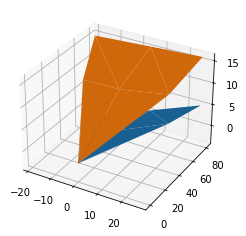

In [2]:
from mpl_toolkits.mplot3d import Axes3D

node = mesh.node
n = node[:,0].shape[0]

nx = node[:,0]
ny = node[:,1]

print(node)
print(uh)

uh_ = np.zeros((n,2), dtype=np.float64)

for i in range(n):
    for j in range(2):
        uh_[i,j] = uh[i,j]

fig = plt.figure()
ax  = fig.add_subplot(111,projection='3d')

ax.plot_trisurf(nx, ny, uh_[:,0])
ax.plot_trisurf(nx, ny, uh_[:,1])

In [ ]:
`